# Twitter Sentiment Analysis

This notebook aims to analyze Tweets made about the COVID-19 vaccine and determine whether the sentiment of the Tweets is negative, positive, or neutral.

## Libraries

In [66]:
import tweepy
import webbrowser
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import config
pd.set_option('display.max_colwidth', None)

from tweepy import OAuthHandler
from tweepy import API

import os
from google.oauth2 import service_account
from google.cloud import translate_v2 as translate

import nltk
from nltk.corpus import gutenberg, stopwords
from nltk import FreqDist
from nltk.tokenize import TweetTokenizer, word_tokenize
import string

import re
from textblob import TextBlob
from wordcloud import WordCloud

## Gather data from Twitter API

In [2]:
# Developer API keys
# API keys in config.py in .gitignore
callback_uri = 'oob'

In [3]:
auth = OAuthHandler(config.consumer_key, config.consumer_secret, callback_uri)
auth.set_access_token(config.access_token, config.access_token_secret)

In [4]:
api = API(auth, wait_on_rate_limit= True, wait_on_rate_limit_notify= True)

In [5]:
# show my Twitter handle
me = api.me()
print(me.screen_name)

cassienutter1


In [45]:
# simple query to get the hang of it
query = '#vaccine covid -RT -@ -http'
for i, status in enumerate(tweepy.Cursor(api.search, q= query).items(15)):
    print (i, status.text)

# filter only English tweets    
# query = '#vaccine covid'
# for i, status in enumerate(tweepy.Cursor(api.search, q= query, lang= 'en').items(50)):
#     print (i, status.text)

0 Just saw fully vaccinated in a Tinder bio. What a time to be alive. #covid #vaccine #tinder
1 This. Ugh. #covid #vaccine  https://t.co/A3F1SkppjW
2 #DearMother #AlternativeMetal #Metal #Album #Covid_19 #coronavirus #Pandemia #pandemic #vaccine https://t.co/szuSduwRTN
3 THREAD #NYC #covid #vaccine https://t.co/cnorAyR6zk
4 Until y’all understand that vaccination passports are only ok if the vaccine is equitably available, maybe shut the… https://t.co/4vqdzl7B0a
5 Plan and prepare for your COVID-19 vaccination. #vaccine 
https://t.co/GVO3F2Bgfh https://t.co/EOj9374TEB
6 DEAR MOTHER: Álbum De Estreia Da Banda Tem Lançamento Adiado

Inscreva-se No #Blog, Compartilhe. Apoie o… https://t.co/rfiMz6U2Xf
7 You must have ID to get a COVID vaccine.... just saying. 

#vaccine #VoterID #VoterIntegrity
8 @sbattrawden Got shot #1 of Pfizer yesterday here in NYC @sbattrawden — it was at the big Javitts Center and was so… https://t.co/q81I3s5UFe
9 @CA_OSG @ListosCA 💯 agree! I provide vaccinations in 

In [7]:
''' This cell was run to collect the initial 5000 tweets and save them to a csv file
is commented out to prevent it from being run again


# collect 5000 tweets 
number_of_tweets = 5000
tweets = []
language = []
time = []

# only collect full text, language, and time it was posted
# remove any retweets '-RT'
for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                       tweet_mode = 'extended').items(number_of_tweets):
    tweets.append(i.full_text)
    language.append(i.lang)
    time.append(i.created_at)

# turn tweets / lists into dataframe
df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})

# save df to csv
df.to_csv('data/tweets.csv', index= False)
'''

" This cell was run to collect the initial 5000 tweets and save them to a csv file\nis commented out to prevent it from being run again\n\n\n# collect 5000 tweets \nnumber_of_tweets = 5000\ntweets = []\nlanguage = []\ntime = []\n\n# only collect full text, language, and time it was posted\n# remove any retweets '-RT'\nfor i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  \n                       tweet_mode = 'extended').items(number_of_tweets):\n    tweets.append(i.full_text)\n    language.append(i.lang)\n    time.append(i.created_at)\n\n# turn tweets / lists into dataframe\ndf = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})\n\n# save df to csv\ndf.to_csv('data/tweets.csv', index= False)\n"

Collect more tweets after waiting to avoid collecting the same tweets.

In [8]:
# create function to get more tweets and add to existing csv
def get_more_tweets(num_tweets):
    number_of_tweets = num_tweets
    tweets = []
    language = []
    time = []

    # only collect full text, language, and time it was posted
    # remove any retweets '-RT'
    for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                           tweet_mode = 'extended').items(number_of_tweets):
        tweets.append(i.full_text)
        language.append(i.lang)
        time.append(i.created_at)
        
    # turn tweets / lists into dataframe
    df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})
    
    # add to existing csv file
    df.to_csv('data/tweets.csv', mode= 'a', index= False, header= False)

In [9]:
# get tweets and save to csv through function

# n_tweets = 20
# get_more_tweets(n_tweets)

### Search for Tweets from 30 Days Ago

In [10]:
# function to turn results into DataFrame
def extract_text_as_df(text_list):
    columns = set()
    allowed_types = [str, int]
    tweets_data = []
    for status in text_list:
        status_dict = dict(vars(status))
        keys = status_dict.keys()
        single_tweet_data = {"author": status.author.screen_name}
        for k in keys:
            try:
                v_type = type(status_dict[k])
            except:
                v_type = None
            if v_type != None:
                if v_type in allowed_types:
                    single_tweet_data[k] = status_dict[k]
                    columns.add(k)
        tweets_data.append(single_tweet_data)


    header_cols = list(columns)
    header_cols.append('author')
    df = pd.DataFrame(tweets_data, columns=header_cols)
    return df

In [11]:
query = 'vaccine covid -RT'
results_30 = api.search_30_day('datacollection', query, maxResults= 100)

In [12]:
old_results_df = extract_text_as_df(results_30)

In [13]:
old_results_df

,lang,source_url,id,quote_count,favorite_count,in_reply_to_screen_name,in_reply_to_user_id,in_reply_to_user_id_str,retweet_count,quoted_status_id,in_reply_to_status_id,filter_level,quoted_status_id_str,in_reply_to_status_id_str,source,reply_count,id_str,text,author
0,hi,https://mobile.twitter.com,1378769944070868992,0,0,drdwivedisatish,1.680194e+09,1680193604,0,NaN,1.378671e+18,low,NaN,1378671071239401472,Twitter Web App,0,1378769944070868992,@drdwivedisatish @BJP4UP सर जिन विद्यालयों में कोई प्रशाशनिक कार्य लंबित नही है वहाँ भी शिक्षक को प्रतिदिन जाना है?… https://t.co/rPiDBfj0Ix,kamalna26924906
1,en,https://mobile.twitter.com,1378769938555539456,0,0,Logjeet,7.413575e+17,741357450817736704,0,NaN,1.378617e+18,low,NaN,1378617383242268675,Twitter Web App,0,1378769938555539456,@Logjeet @KEEMSTAR Yall acting like covid is The black plague. If it was more deadly people would want the vaccine… https://t.co/lBxaySBTy7,dudeman89179543
2,en,http://twitter.com/download/iphone,1378769891138867201,0,0,NaN,NaN,NaN,0,NaN,NaN,low,NaN,NaN,Twitter for iPhone,0,1378769891138867201,J&amp;J’s COVID-19 vaccine emerges as preferred shot for homeless - The Wall Street Journal https://t.co/Q2EGVgV7V8,DimitriLyon
3,en,https://mobile.twitter.com,1378769877176086530,0,0,suepeac,1.836074e+07,18360735,0,NaN,1.378768e+18,low,NaN,1378768302927867905,Twitter Web App,0,1378769877176086530,@suepeac @TedDixon @SouthMacedonian @lisa_iannattone @KashPrime so why so far behind other countries? and now igno… https://t.co/iU5AgjUkdj,awri125
4,en,https://mobile.twitter.com,1378769873094987777,0,0,NaN,NaN,NaN,0,NaN,NaN,low,NaN,NaN,Twitter Web App,0,1378769873094987777,Can everyone please differentiate between domestic covid status certificates and international vaccine passports fo… https://t.co/heJ706wsMI,rockmeamadeus6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,und,http://twitter.com/download/android,1378769258956652544,0,1,swizze_gfrank,7.388900e+17,738889961429176320,0,NaN,1.378712e+18,low,NaN,1378711876339703808,Twitter for Android,0,1378769258956652544,@swizze_gfrank @AlexBerenson https://t.co/tMOh4aPlAL,melico24
96,en,http://twitter.com/download/iphone,1378769251343929350,0,0,NaN,NaN,NaN,0,NaN,NaN,low,NaN,NaN,Twitter for iPhone,0,1378769251343929350,"U.S. puts J&amp;J in charge of plant that botched COVID vaccine, removes AstraZeneca - Reuters Smart move ! This should… https://t.co/ZU1s50Fn6w",Thelast_try
97,fr,https://mobile.twitter.com,1378769248147886087,0,1,NaN,NaN,NaN,0,NaN,NaN,low,NaN,NaN,Twitter Web App,0,1378769248147886087,"COVID-19 : (tjrs) pris pour des cons !\nLe bal des masqués !\nLe vaccin, le vaccin ! #StopVaccination \nLe QR code en… https://t.co/2oWGV7Qlwg",MartinaDeBX
98,en,http://twitter.com/download/android,1378769244477927427,0,0,NaN,NaN,NaN,0,1.378763e+18,NaN,low,1378762538708566019,NaN,Twitter for Android,0,1378769244477927427,"Chief @Riqblaze see what we were discussing the other day! Yes, Covid-19 is bad but the wartime effort it generated… https://t.co/JToyqq3LEQ",David_Biyi


## Data Cleaning & EDA

In [14]:
df = pd.read_csv('data/tweets.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19450 entries, 0 to 19449
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      19450 non-null  object
 1   language  19450 non-null  object
 2   tweets    19450 non-null  object
dtypes: object(3)
memory usage: 456.0+ KB


### Check and Remove Duplicates

In [16]:
# check for duplicated tweets
duped = df[df.duplicated(subset= 'tweets')]
duped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 812 to 19444
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      52 non-null     object
 1   language  52 non-null     object
 2   tweets    52 non-null     object
dtypes: object(3)
memory usage: 1.6+ KB


In [17]:
# remove duplicates
df.drop_duplicates(subset= 'tweets', keep= 'first', inplace= True)
df.reset_index(drop= True, inplace= True)

# make sure they are gone
df.tweets.duplicated().sum()

0

### Looking at Languages

In [18]:
lang_df = df.sort_values('language')

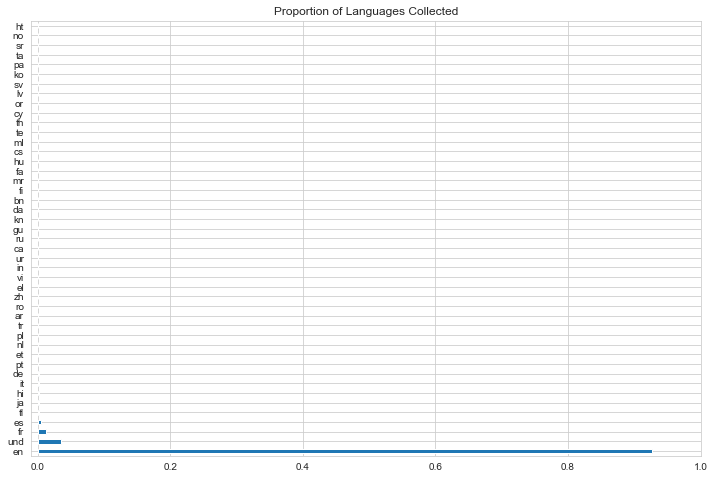

In [19]:
plt.figure(figsize= (12, 8))
lang_df.language.value_counts(normalize=True).plot(kind= 'barh')
plt.title('Proportion of Languages Collected')
plt.xlim(-.01, 1)
plt.show()

In [20]:
lang_df.language.value_counts(normalize=True)

en     0.926333
und    0.035725
fr     0.011857
es     0.004485
tl     0.002371
ja     0.002062
hi     0.002011
it     0.001392
de     0.001340
pt     0.001186
et     0.001083
nl     0.000928
pl     0.000722
tr     0.000670
ar     0.000619
ro     0.000464
zh     0.000464
el     0.000464
vi     0.000412
in     0.000412
ur     0.000412
ca     0.000412
ru     0.000361
gu     0.000361
kn     0.000309
da     0.000309
bn     0.000309
fi     0.000258
mr     0.000258
fa     0.000206
hu     0.000206
cs     0.000155
ml     0.000155
te     0.000155
th     0.000155
cy     0.000155
or     0.000155
lv     0.000103
sv     0.000103
ko     0.000103
pa     0.000103
ta     0.000103
sr     0.000052
no     0.000052
ht     0.000052
Name: language, dtype: float64

In [21]:
# what are these languages? get table from url
URL = 'https://developer.twitter.com/en/docs/twitter-for-websites/supported-languages'
tables = pd.read_html(URL)
print("There are : ",len(tables)," tables")
print(tables[0])

lang_table = tables[0]

There are :  1  tables
                        0              1
0                    Name  Language code
1       English (default)             en
2                  Arabic             ar
3                 Bengali             bn
4                   Czech             cs
5                  Danish             da
6                  German             de
7                   Greek             el
8                 Spanish             es
9                 Persian             fa
10                Finnish             fi
11               Filipino            fil
12                 French             fr
13                 Hebrew             he
14                  Hindi             hi
15              Hungarian             hu
16             Indonesian             id
17                Italian             it
18               Japanese             ja
19                 Korean             ko
20                  Malay            msa
21                  Dutch             nl
22              Norwegian         

In [22]:
# format table
header_row = 0
lang_table.columns = lang_table.iloc[header_row]
lang_table = lang_table.drop(header_row)
lang_table.reset_index(drop= True, inplace= True)

lang_table.replace('English (default)', 'English', inplace= True)
# lang_table

In [23]:
# save as csv in data folder
lang_table.to_csv('data/languages.csv', index= False)

In [24]:
# look at 'und' language 
df[df['language'] == 'und']

,time,language,tweets
1,2021-04-01 21:58:44,und,@and_kell @ds13_manon https://t.co/sKnTctMKcF
19,2021-04-01 21:58:14,und,https://t.co/j2braq4wFx
29,2021-04-01 21:57:58,und,@Pavlos80322302 @ds13_manon https://t.co/sKnTctMKcF
79,2021-04-01 21:56:21,und,👍🏼👍🏼👍🏼👍🏼 https://t.co/m68KkEqpOe
97,2021-04-01 21:55:44,und,https://t.co/Stomi0I13k
...,...,...,...
19289,2021-04-04 16:40:46,und,@deniseramosm https://t.co/Hi3OGdXTeP\n⬇️
19317,2021-04-04 16:39:30,und,https://t.co/WRugcVZRqr
19372,2021-04-04 16:37:17,und,الحمدلله 🙏🏽💉 (@ COVID-19 Vaccine Center - @saudimoh in الرياض) https://t.co/zfzBWyp4Tg
19373,2021-04-04 16:37:14,und,https://t.co/J54pSG93KG


It appears that the 'und' or possibly 'undetermined' language are tweets that do not include text to help us with our sentiment analysis. We will remove those from our DataFrame.

In [25]:
df = df[df['language'] != 'und']
# df.info()

Merge the data with the languages to see the whole name of languages

In [26]:
# merge data with language names
df2 = df.merge(lang_table, how= 'inner', left_on= 'language', right_on= 'Language code')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18575 entries, 0 to 18574
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   time           18575 non-null  object
 1   language       18575 non-null  object
 2   tweets         18575 non-null  object
 3   Name           18575 non-null  object
 4   Language code  18575 non-null  object
dtypes: object(5)
memory usage: 870.7+ KB


In [27]:
# drop extra columns and rename them and change dates to datetime and drop time
df2.drop(columns = ['language', 'Language code'], inplace= True)
df2.rename(columns={'Name': 'language'}, inplace= True)
df2['time'] = pd.to_datetime(df2['time']).dt.date
# df2

Let's see how many Tweets are in each language?

<AxesSubplot:xlabel='count', ylabel='language'>

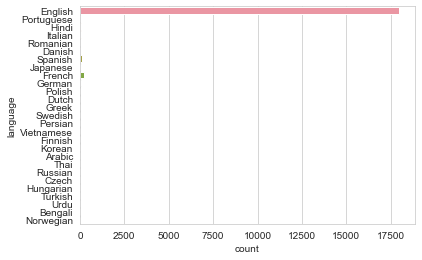

In [28]:
sns.countplot(y= 'language', data= df2)

The majority of Tweets are in English. Let's see what the other languages are.

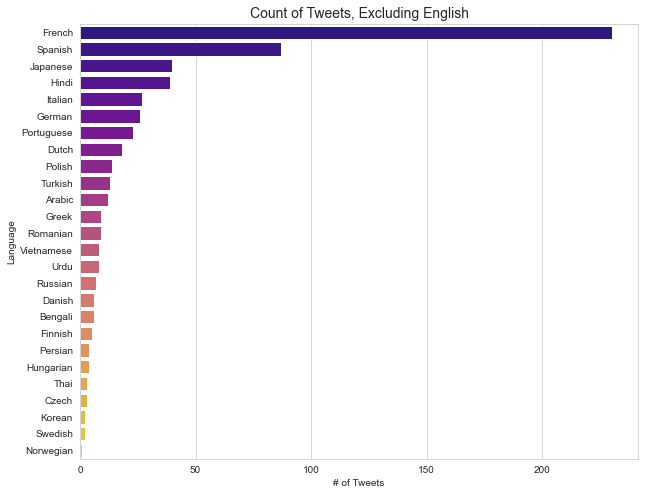

In [29]:
# countplot that excludes English to see detail
plt.figure(figsize= (10, 8))
sns.countplot(y= 'language', data= df2, palette='plasma',
              order= df2.language.value_counts().iloc[1:].index)
plt.title('Count of Tweets, Excluding English', fontsize= 14)
plt.xlabel('# of Tweets')
plt.ylabel('Language')
plt.show()

After English, the top 3 languages for Tweets about the COVID-19 vaccine are in French, Spanish, and Japanese.

In [43]:
df2.head(10)

,time,tweets,language
0,2021-04-01,"Concerning the use of aborted baby tissue in the J&amp;J Covid vaccine:\n\n“The J&amp;J vaccine has sparked debate among some religious communities because it was developed from stem cells obtained during two abortions decades ago.”\n\nEvil is still evil, even if it was decades ago.",English
1,2021-04-01,imagine an animal getting the covid-19 vaccine b4 a human,English
2,2021-04-01,Definition of a microstate: https://t.co/8N0R8Mhl73\n\nSource of vaccine data: https://t.co/0RQFJPTrZZ,English
3,2021-04-01,"If I’ve Had COVID-19, Do I Still Need Two Doses of Vaccine? https://t.co/08AiBgfEHQ",English
4,2021-04-01,"My epidural was delayed again, somehow my covid vaccine does not interact well with an epidural. SOOOOO I should be getting it on my birthday. Yay. \n\n So far I have 1-2 dr appointments a week this entire month.\n \nOn the upside they've given me proper muscle relaxers this time.",English
5,2021-04-01,Blake Lively hilariously called out her husband Ryan Reynolds for what he posted after they got their COVID-19 vaccine shots https://t.co/GixfzNnHBc,English
6,2021-04-01,@Kit_Yates_Maths Tests\n1. Vax deployment ✅✅\n2. Vax reduces hospitalisation ✅✅\n3. Infection rates unsubstantiated pressure on NHS ✅\n4. Variants of concern ☑️\n\nSo not measured but very conservative \nhttps://t.co/iVMKF2pPsF https://t.co/ta4t21HH9s,English
7,2021-04-01,Here’s how you can be forced to get the Covid vaccine in the US https://t.co/dparLwxbq2,English
8,2021-04-01,"I received my second dose of the Covid-19 vaccine today. I’m grateful, and hopeful for a return to normalcy on the horizon. I want to thank everyone working so hard to get folks vaccinated. Get your vaccine here: https://t.co/YAl9dOBkLo #GetYourShot #vaccinated https://t.co/WH5AdwbgkP",English
9,2021-04-01,@JoshMatlow Ok how many times has this How do we have vaccine clinics in areas where Covid cases are highest ?\nOr most important paid sick leave?\nPlease Mr Matlow what we can we the ordinary citizen do? It seems you are unable to do anything? I am pleading with you do something!,English


#### Translate to English using Google Cloud Platform's API

In [30]:
# send in credentials that are saved on local computer
credentials = service_account.Credentials.from_service_account_file('../GCP_service_account.json')
translate_client = translate.Client(credentials= credentials)

In [31]:
# see all languages that Google can translate
print(translate_client.get_languages())

[{'language': 'af', 'name': 'Afrikaans'}, {'language': 'sq', 'name': 'Albanian'}, {'language': 'am', 'name': 'Amharic'}, {'language': 'ar', 'name': 'Arabic'}, {'language': 'hy', 'name': 'Armenian'}, {'language': 'az', 'name': 'Azerbaijani'}, {'language': 'eu', 'name': 'Basque'}, {'language': 'be', 'name': 'Belarusian'}, {'language': 'bn', 'name': 'Bengali'}, {'language': 'bs', 'name': 'Bosnian'}, {'language': 'bg', 'name': 'Bulgarian'}, {'language': 'ca', 'name': 'Catalan'}, {'language': 'ceb', 'name': 'Cebuano'}, {'language': 'ny', 'name': 'Chichewa'}, {'language': 'zh-CN', 'name': 'Chinese (Simplified)'}, {'language': 'zh-TW', 'name': 'Chinese (Traditional)'}, {'language': 'co', 'name': 'Corsican'}, {'language': 'hr', 'name': 'Croatian'}, {'language': 'cs', 'name': 'Czech'}, {'language': 'da', 'name': 'Danish'}, {'language': 'nl', 'name': 'Dutch'}, {'language': 'en', 'name': 'English'}, {'language': 'eo', 'name': 'Esperanto'}, {'language': 'et', 'name': 'Estonian'}, {'language': 'tl'

In [32]:
# separate non-English tweets for faster translating
part_df = df2.loc[16100:]
# part_df.language.value_counts(normalize= True)

In [33]:
# create dictionary to save original tweet and translated one
results = {}

# translate tweets into English
for i in part_df.tweets.loc[:]:
    result = translate_client.translate(i, target_language= 'en')
    results[i] = result['translatedText']

In [34]:
# replace with English translation
df2.tweets.replace(results, inplace= True)

In [35]:
# preview previously French Tweets
df2[df2['language'] == 'French']

,time,tweets,language
18200,2021-04-01,"@ BenoitG70293865 @francoislegault Haha! This guy is my spiritual animal 🤣 No, but do you have to be thick to ask a vaccinated guy if he&#39;s afraid of the Covid?",French
18201,2021-04-01,"So my father, who has been fighting multiple sclerosis for over 10 years now, must be vaccinated against covid on the pretext that he is a person at risk ?? A PERSON AT RISK ???? It&#39;s not like he got this damn disease from a FUCKING VACCINE !!",French
18202,2021-04-01,"@ Latnaille77 They are quite right! Had he had a serological check before his vaccination! Perhaps he had already had an asymptomatic form of covid and was immune. We do not vaccinate in this case. But hey, since everything is done in spite of common sense, how many victims to deplore 😪",French
18203,2021-04-01,@ Digitalchaos8 @ Poulin2012 My neighbor duly vaccinated in the 1st serious Covid ...,French
18204,2021-04-01,Gold D Roger is said to have actually died after being vaccinated against Covid-19. https://t.co/OvoulfUryJ,French
...,...,...,...
18425,2021-04-04,"@LeHuffPost Do you have measles? Yes, but I&#39;m vaccinated against covid so it&#39;s okay.",French
18426,2021-04-04,@MontsarratJ @BFMTV But when you vaccinate you could be in asymptomatic incubation .. you tell me about people who we know are covid + and there yes it takes 3 months before vaccinated .... the probability of being vaccinated and in incubation and minimal,French
18427,2021-04-04,@CampagnolTVL but why was he vaccinated? I thought that having had the covid exempted from the vaccination because of the antibodies?,French
18428,2021-04-04,"Nice Russian vaccine that @cestrosi And @MLP_officiel want to inoculate us. Once again a good pick for the geniuses of the far right. BFMTV: Vaccinated with Sputnik V, the Argentine president tested positive for Covid-19. https://t.co/k7wcFyaxTP",French


In [36]:
# save to csv file
df2.to_csv('data/tweets_translated.csv', index= False)

## Text Sentiment
---
Does the tweet have a positive, negative, or neutral tone?

### Feature Engineering for Text Data
--- 
stopword removal
frequency distributions
lemmatization
bigramsm n-grams, and mutal information score

In [37]:
sentiment_df = df2[['time', 'tweets']]

In [38]:
sentiment_df.head()

,time,tweets
0,2021-04-01,"Concerning the use of aborted baby tissue in the J&amp;J Covid vaccine:\n\n“The J&amp;J vaccine has sparked debate among some religious communities because it was developed from stem cells obtained during two abortions decades ago.”\n\nEvil is still evil, even if it was decades ago."
1,2021-04-01,imagine an animal getting the covid-19 vaccine b4 a human
2,2021-04-01,Definition of a microstate: https://t.co/8N0R8Mhl73\n\nSource of vaccine data: https://t.co/0RQFJPTrZZ
3,2021-04-01,"If I’ve Had COVID-19, Do I Still Need Two Doses of Vaccine? https://t.co/08AiBgfEHQ"
4,2021-04-01,"My epidural was delayed again, somehow my covid vaccine does not interact well with an epidural. SOOOOO I should be getting it on my birthday. Yay. \n\n So far I have 1-2 dr appointments a week this entire month.\n \nOn the upside they've given me proper muscle relaxers this time."


In [ ]:
# remove amp; and @ and https then run through Google NLP

### Google Cloud Platform Natural Language Processing

In [ ]:
nlp_client = language.Client(credentials = credentials)

In [39]:
# convert text to lowercase and remove stopwords
def process_tweets(tweet):
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed

In [40]:
# import nltk
# nltk.download('punkt')

In [41]:
sentiment_df = sentiment_df.apply(lambda x: process_tweets(x) if x.name == 'tweets' else x)

TypeError: expected string or bytes-like object

### Sentiment Analysis with TextBlob

In [56]:
# functions to clean tweets, get subjectivity and polarity scores and sentiment
def cleanTweet(txt):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", 
                           " ", txt).split())

def getTextSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def getTextPolarity(txt):
    return TextBlob(txt).sentiment.polarity

def getTextAnalysis(p):
    if p < 0:
        return "Negative"
    elif p == 0:
        return "Neutral"
    else:
        return "Positive"

In [57]:
# apply functions to tweets
sentiment_df['tweets'] = sentiment_df['tweets'].apply(clean_tweet)
sentiment_df['Subjectivity'] = sentiment_df['tweets'].apply(getTextSubjectivity)
sentiment_df['Polarity'] = sentiment_df['tweets'].apply(getTextPolarity)
sentiment_df['TextBlob Score'] = sentiment_df['Polarity'].apply(getTextAnalysis)
sentiment_df

,time,tweets,TB sentiment,Subjectivity,Polarity,TextBlob Score
0,2021-04-01,Concerning the use of aborted baby tissue in the J amp J Covid vaccine The J amp J vaccine has sparked debate among some religious communities because it was developed from stem cells obtained during two abortions decades ago Evil is still evil even if it was decades ago,negative,0.637500,-0.475000,Negative
1,2021-04-01,imagine an animal getting the covid 19 vaccine b4 a human,neutral,0.100000,0.000000,Neutral
2,2021-04-01,Definition of a microstate Source of vaccine data,neutral,0.000000,0.000000,Neutral
3,2021-04-01,If I ve Had COVID 19 Do I Still Need Two Doses of Vaccine,neutral,0.000000,0.000000,Neutral
4,2021-04-01,My epidural was delayed again somehow my covid vaccine does not interact well with an epidural SOOOOO I should be getting it on my birthday Yay So far I have 1 2 dr appointments a week this entire month On the upside they ve given me proper muscle relaxers this time,positive,0.575000,0.033333,Positive
...,...,...,...,...,...,...
18570,2021-04-02,Umrah can be performed without vaccination in Ramadan PuberKalom umrah Hajj Ramdan SaudiArabia Covid Vaccine,neutral,0.000000,0.000000,Neutral
18571,2021-04-03,Nurse busy on mobile one person was vaccinated twice PuberKalom Mobile Covid vaccine UttarPradesh nurses,positive,0.300000,0.100000,Positive
18572,2021-04-03,While talking on the phone the nurse vaccinated the woman not to take 2 doses at once then Coronavirus CoronaVaccine News18Bangla,neutral,0.000000,0.000000,Neutral
18573,2021-04-04,Covid 19 Vaccine Registration Easy way to register for Corona Vaccine Coronavirus Covid 19 AagrogyaSetu,positive,0.833333,0.433333,Positive


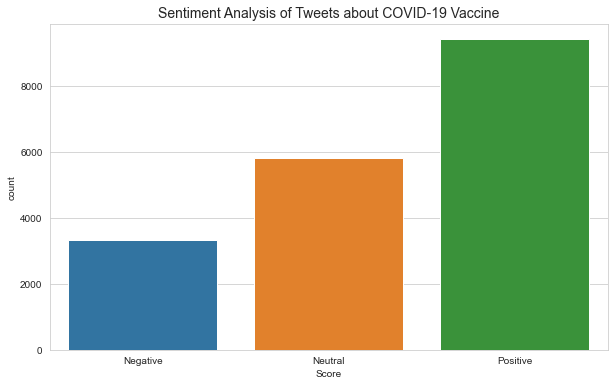

In [62]:
# plot as bar graph
plt.figure(figsize= (10, 6))
sns.countplot(data= sentiment_df, x = 'TextBlob Score')
plt.title('Sentiment Analysis of Tweets about COVID-19 Vaccine', fontsize = 14)
plt.xlabel('Score')
plt.show()

KeyboardInterrupt: 

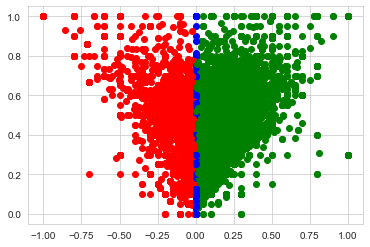

In [64]:
for index, row in sentiment_df.iterrows():
    if row['TextBlob Score'] == 'Positive':
        plt.scatter(row['Polarity'], row['Subjectivity'], color="green")
    elif row['TextBlob Score'] == 'Negative':
        plt.scatter(row['Polarity'], row['Subjectivity'], color="red")
    elif row['TextBlob Score'] == 'Neutral':
        plt.scatter(row['Polarity'], row['Subjectivity'], color="blue")

plt.title('Twitter Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
# add legend
plt.show()

### Word Cloud

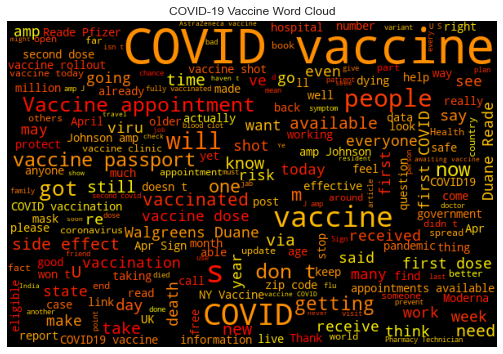

In [70]:
words = ' '.join([tweet for tweet in sentiment_df['tweets']])
wc = WordCloud(width=600, height=400).generate(words)
plt.figure(figsize= (10, 6))
plt.imshow(wc.recolor(colormap= 'autumn'))
plt.axis('off')
plt.title('COVID-19 Vaccine Word Cloud')
plt.show()